In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
sys.path.append('..')
from load_data import load_data, Dataset
from config import xvertseg_dir, verse2019_dir, resolution, patch_size
import seaborn as sns

In [2]:
# load data from corresponding data dir
xvertseg_imgs, xvertseg_msks, xvertseg_scores = load_data(xvertseg_dir)
verse2019_imgs, verse2019_msks, verse2019_scores = load_data(verse2019_dir)

Loading images from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/images...
Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/masks...
Loading images from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/images...
Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/masks...


In [3]:
# stack data sets together
imgs = np.concatenate((xvertseg_imgs, verse2019_imgs))
msks = np.concatenate((xvertseg_msks, verse2019_msks))
scores = xvertseg_scores.append(verse2019_scores)
display(scores)

,Dataset,ID,T1 grade,T1 case,T2 grade,T2 case,T3 grade,T3 case,T4 grade,T4 case,...,L2 grade,L2 case,L3 grade,L3 case,L4 grade,L4 case,L5 grade,L5 case,L6 grade,L6 case
0,xvertseg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN
1,xvertseg,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
2,xvertseg,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,NaN,NaN
3,xvertseg,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,NaN
4,xvertseg,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,verse2019,270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
116,verse2019,272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
117,verse2019,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
118,verse2019,276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


### Statistics about this dataset (from scoresheet)
Things like:
* distribution of vertebra type
* the frequency of fractures (distribution when we have different cases and grades)

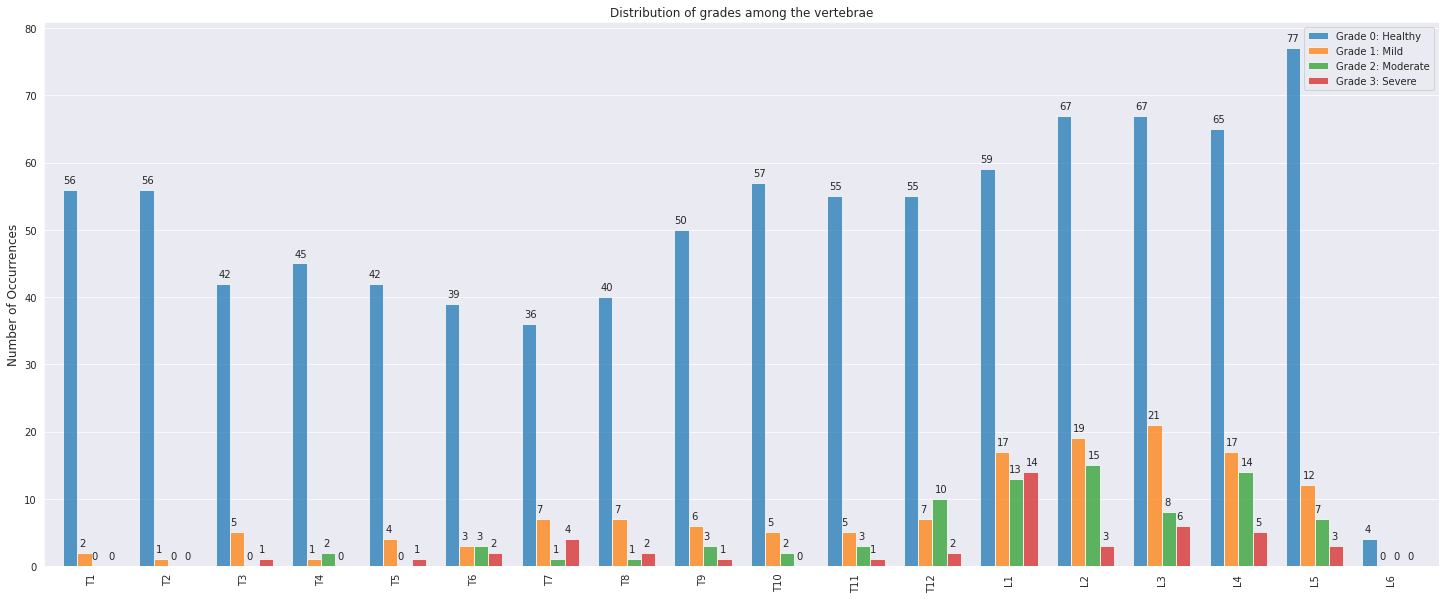

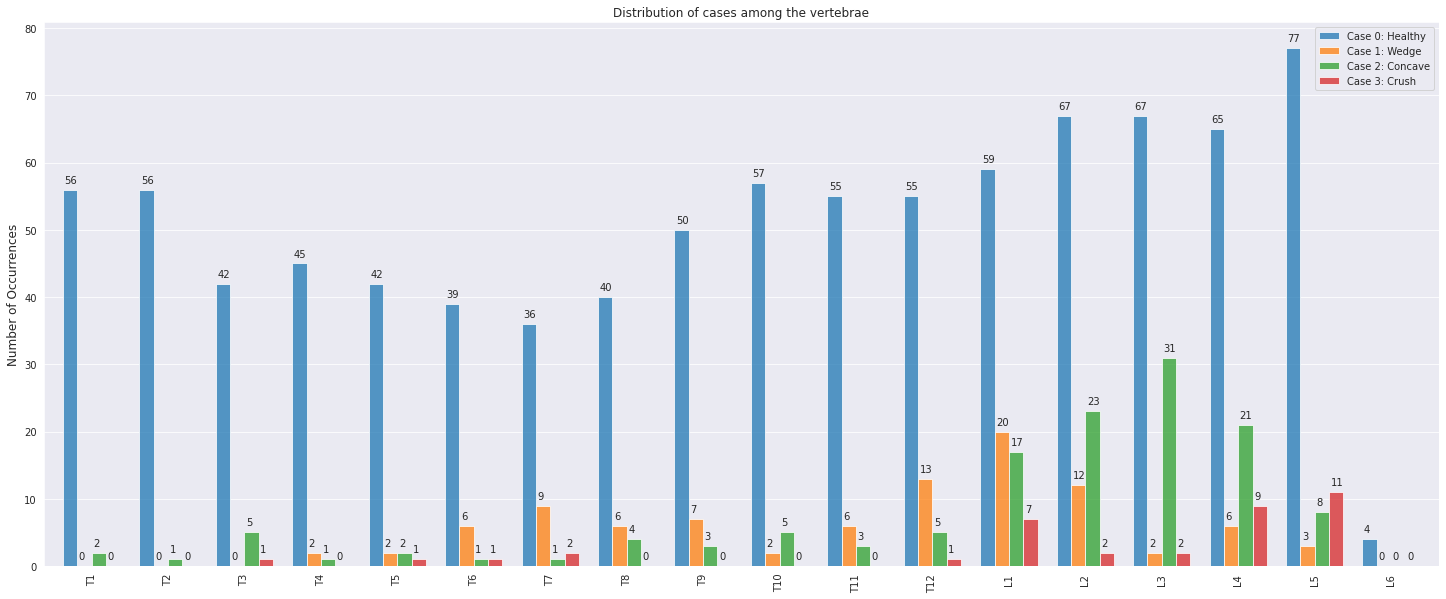

In [8]:
grades = scores.columns[2::2]
cases = scores.columns[3::2]

# per vertebrae statistics
counts_grades = np.array([scores.iloc[:, 2:][grade].value_counts(bins=[-0.5, 0.5, 1.5, 2.5, 3.5], sort=False) for grade in grades])
counts_cases = np.array([scores.iloc[:, 2:][case].value_counts(bins=[-0.5, 0.5, 1.5, 2.5, 3.5], sort=False) for case in cases])  

# total statistics
total_counts_grades = (np.sum(counts_grades, axis=0))
total_counts_cases = (np.sum(counts_cases, axis=0))

sns.set_style("dark")
index = np.asarray(['T{}'.format(i) for i in range(1, 13)] + ['L{}'.format(i) for i in range(1, 7)])
df = pd.DataFrame({'Grade 0: Healthy': counts_grades[:, 0], 
                   'Grade 1: Mild': counts_grades[:, 1],
                   'Grade 2: Moderate': counts_grades[:, 2],
                   'Grade 3: Severe': counts_grades[:, 3]}, index=index)
bars = df.plot.bar(figsize=(25, 10), width=0.75, alpha=0.75)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of grades among the vertebrae')
plt.gca().yaxis.grid()

# plot the counts on top
for i, p in enumerate(bars.patches):
    x = (p.get_x() + p.get_width() // 2)
    x = x + 0.03 if (i % 4) != 0 else x
    y = p.get_y() + p.get_height() + 1
    bars.annotate(counts_grades.T.flatten()[i], (x, y))
        
plt.show()

df = pd.DataFrame({'Case 0: Healthy': counts_cases[:, 0], 
                   'Case 1: Wedge': counts_cases[:, 1],
                   'Case 2: Concave': counts_cases[:, 2],
                   'Case 3: Crush': counts_cases[:, 3]}, index=index)
bars = df.plot.bar(figsize=(25, 10), width=0.75, alpha=0.75)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Distribution of cases among the vertebrae')
plt.gca().yaxis.grid()

# plot the counts on top
for i, p in enumerate(bars.patches):
    x = (p.get_x() + p.get_width() // 2) + 0.02
    y = p.get_y() + p.get_height() + 1
    bars.annotate(counts_cases.T.flatten()[i], (x, y))
plt.show()

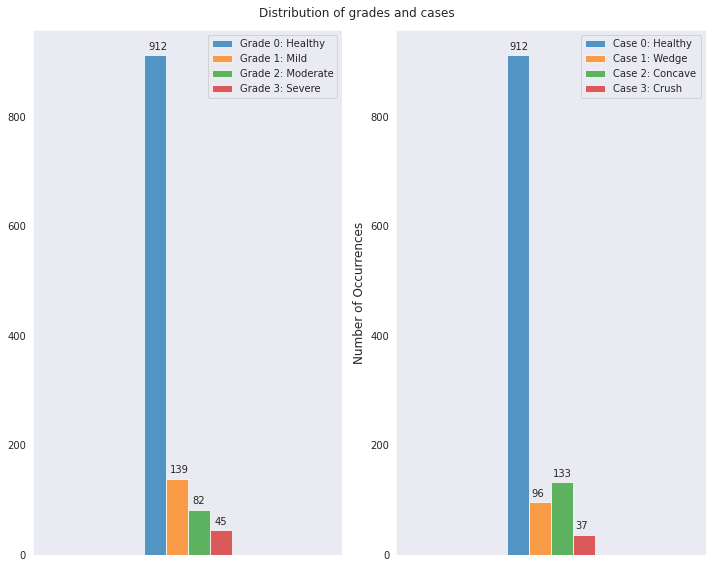

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
df = pd.DataFrame({'Grade 0: Healthy': total_counts_grades[0], 
                   'Grade 1: Mild': total_counts_grades[1],
                   'Grade 2: Moderate': total_counts_grades[2],
                   'Grade 3: Severe': total_counts_grades[3]}, index=[''])

bars = df.plot.bar(width=0.2, alpha=0.75, ax=axes[0])

# plot the counts on top
for i, p in enumerate(bars.patches):
    x = (p.get_x() + p.get_width() // 2) + 0.01
    y = p.get_y() + p.get_height() + 10
    bars.annotate(total_counts_grades[i], (x, y))
    
plt.ylabel('Number of Occurrences', fontsize=12)

df = pd.DataFrame({'Case 0: Healthy': total_counts_cases[0], 
                   'Case 1: Wedge': total_counts_cases[1],
                   'Case 2: Concave': total_counts_cases[2],
                   'Case 3: Crush': total_counts_cases[3]}, index=[''])
bars = df.plot.bar(width=0.2, alpha=0.75, ax=axes[1])

for i, p in enumerate(bars.patches):
    x = (p.get_x() + p.get_width() // 2) + 0.005
    y = p.get_y() + p.get_height() + 10
    bars.annotate(total_counts_cases[i], (x, y))
plt.ylabel('Number of Occurrences', fontsize=12)

plt.ylabel('Number of Occurrences', fontsize=12)
plt.suptitle('Distribution of grades and cases')
plt.tight_layout()
plt.show()

### Statistics about this dataset (from scoresheet + masks)

In [ ]:
# make a dataset
np_scores = scores.to_numpy()
full_dataset = Dataset(np_scores, imgs, msks, patch_size)

In [ ]:
sources = full_dataset.get_sources()
ids = full_dataset.get_ids()
vertebrae = full_dataset.get_vertebrae()
fractured = full_dataset.get_scores()

In [ ]:
# for plotting
vert_names = np.asarray(['T{}'.format(i) for i in range(1, 13)] + ['L{}'.format(i) for i in range(1, 7)])

In [ ]:
ind_xvert = np.argwhere(sources == 'xvertseg')
ind_verse = np.argwhere(sources == 'verse2019')
ind_fractured = np.argwhere(fractured)

# fractured counts
_, counts_xvert_frac = np.unique(vertebrae[np.intersect1d(ind_xvert, ind_fractured)], return_counts=True)
_, counts_verse_frac = np.unique(vertebrae[np.intersect1d(ind_verse, ind_fractured)], return_counts=True)
_, counts_both_frac = np.unique(vertebrae[ind_fractured], return_counts=True)

# all counts fractured counts
labels_xvert, counts_xvert = np.unique(vertebrae[ind_xvert], return_counts=True)
labels_verse, counts_verse = np.unique(vertebrae[ind_verse], return_counts=True)
labels_both, counts_both = np.unique(vertebrae, return_counts=True)

# hack but ok
counts_verse_frac = np.append(counts_verse_frac, [0])
counts_both_frac = np.append(counts_both_frac, [0])

counts_xvert_non_frac = counts_xvert - counts_xvert_frac
counts_verse_non_frac = counts_verse - counts_verse_frac
counts_both_non_frac = counts_both - counts_both_frac

plt.figure(figsize=(30, 6))
plt.subplot(1, 3, 1)
plt.bar(labels_xvert, counts_xvert_frac, align='center', label='Fractured')
plt.bar(labels_xvert, counts_xvert_non_frac, align='center', label='Healthy', bottom=counts_xvert_frac)
plt.title('Histogram: type of vertebrae in xVertSeg')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_xvert)
plt.gca().set_xticklabels(vert_names[-6:-1])
plt.gca().set_ylim((0, 125))
plt.subplot(1, 3, 2)
plt.bar(labels_verse, counts_verse_frac, align='center', label='Fractured')
plt.bar(labels_verse, counts_verse_non_frac, align='center', label='Healthy', bottom=counts_verse_frac)
plt.title('Histogram: type of vertebrae in Verse2019')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_both)
plt.gca().set_xticklabels(vert_names)
plt.gca().set_ylim((0, 125))
plt.subplot(1, 3, 3)
plt.bar(labels_both, counts_both_frac, align='center', label='Fractured')
plt.bar(labels_both, counts_both_non_frac, align='center', label='Healthy', bottom=counts_both_frac)
plt.title('Histogram: type of vertebrae in both')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_both)
plt.gca().set_xticklabels(vert_names)
plt.gca().set_ylim((0, 125))
plt.plot
plt.show()

## Sanity check: plot some patches in the set and verify proper normalization.

In [ ]:
img_patches = full_dataset.get_images()
msk_patches = full_dataset.get_masks()

In [ ]:
print(np.mean(img_patches))
print(np.std(img_patches))
print(np.mean(msk_patches))
print(np.std(msk_patches))

In [ ]:
# plotting we need the min and maxes
img_min, img_max = np.min(img_patches), np.max(img_patches)
msk_min, msk_max = np.min(msk_patches), np.max(msk_patches)

In [ ]:
plt.figure(figsize=(20, 20))

for n in range(25):
    i = np.random.randint(full_dataset.__len__())

    source = sources[i]
    ID =  ids[i]
    vertebra = vertebrae[i]
    frac = fractured[i]
    
    img, msk = img_patches[i], msk_patches[i]
    plt_msk = np.ma.masked_where(msk == np.min(msk), msk)              
    mid_slice = img.shape[0] // 2 
    
    plt.subplot(5, 5, n + 1)
    plt.imshow(img[mid_slice, :, :], cmap='gray', vmin=img_min, vmax=img_max)
    plt.imshow(plt_msk[mid_slice, :, :], alpha=0.5, vmin=msk_min, vmax=msk_max)
    description = '{} ID: {} \n vert {} '.format(source, ID, vert_names[vertebra - 1])
    description += 'fractured' if frac else 'healthy'
    plt.title(description)

plt.tight_layout()
plt.show()